# Image classification from scratch

Description: Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## 1. Введение

В этом примере показано, как выполнить классификацию изображений с нуля, начиная с файлов изображений JPEG на диске, без использования предварительно обученных весов (pre-trained weights) или готовой модели из Keras. Мы демонстрируем рабочий процесс на наборе данных двоичной классификации Kaggle Cats vs Dogs.

Мы используем утилиту image_dataset_from_directory для создания наборов данных (datasets) и используем слои предварительной обработки изображений Keras для стандартизации изображений (Keras image preprocessing layers for image standardization) и увеличения данных (data augmentation), (количества).

## 2. Setup

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

c:\ANACONDA\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 3. Load the data: the Cats vs Dogs dataset

https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [2]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


## 4. Generate a Dataset

In [3]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 27 files belonging to 2 classes.


Using 22 files for training.
Using 5 files for validation.


## 5. Visualize the data

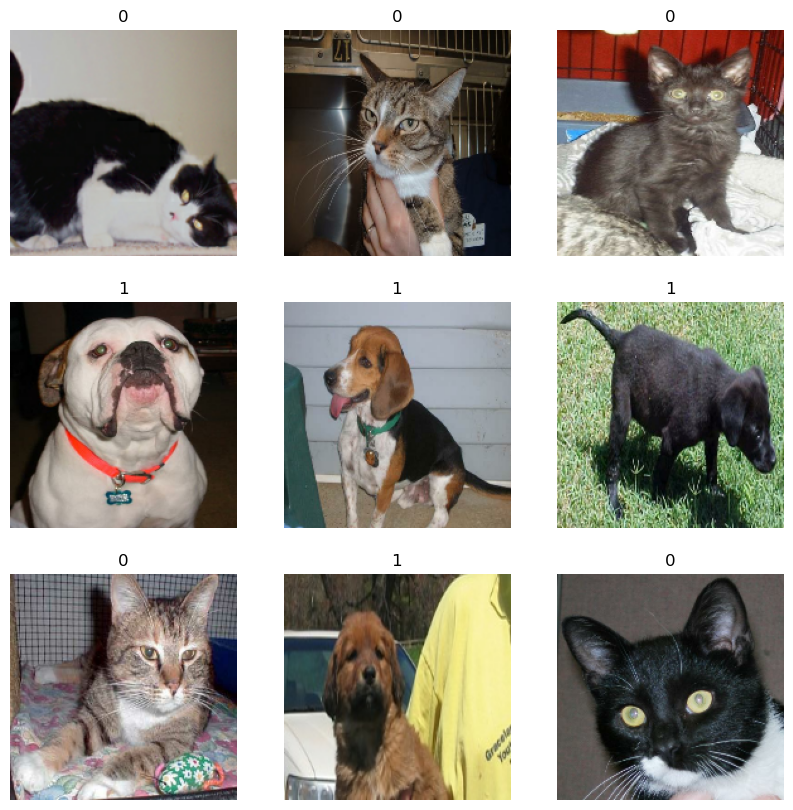

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## 5 Build a model

In [5]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 6 Train the model

In [6]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - acc: 0.5455 - loss: 0.6842 - val_acc: 0.4000 - val_loss: 0.6927
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.5909 - loss: 0.5042 - val_acc: 0.4000 - val_loss: 0.6923
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 0.7273 - loss: 0.3651 - val_acc: 0.4000 - val_loss: 0.6920
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 0.8636 - loss: 0.3419 - val_acc: 0.4000 - val_loss: 0.6918
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 0.9545 - loss: 0.2179 - val_acc: 0.4000 - val_loss: 0.6917
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 1.0000 - loss: 0.1391 - val_acc: 0.4000 - val_loss: 0.6917
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 1.0000 - loss: 0.0863 - val_acc: 0.4000 - val_loss: 0.6918
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 1.0000 - loss: 0.0481 - val_acc: 0.4000 - val_loss: 0.6920
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 1.0000 - loss: 0.0294 - val_acc: 0.4000 - val_loss:

## 7 Run inference on new data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
This image is 50.65% cat and 49.35% dog.


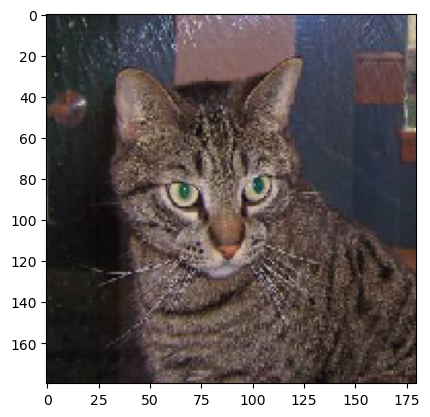

In [7]:
img = keras.utils.load_img("PetImages/Cat/1.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")